In [1]:
import itertools as it
from glob import glob
import warnings
import cv2
import numpy as np
from numpy.polynomial import polynomial as P
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tifffile as tf

from scipy import ndimage, signal, spatial, interpolate
from skimage import morphology

import os
import pandas as pd

from importlib import reload

from sklearn import linear_model as linear
from sklearn import tree, ensemble

In [2]:
maize_palettes = {
  'Anthocyanins1':["#f8f1d9", "#edc262", "#9a3a28", "#581d2c", "#2e1342"],
  'Anthocyanins2':["#f4e8a7", "#e7a96f", "#b05732", "#6a3131", "#2f2929"],
  'RubyGold':["#57170f", "#943124", "#eabf5a", "#f4e093", "#edaa5d", "#e77e39"],
  'Sweetest':["#b2c66b", "#696d2e", "#f9f2b2", "#f1cf62", "#6f4d22"],
  'GlassGem':["#d1aae6", "#6c5ba5", "#e66e58", "#7f346f", "#9d2315"],
  'PodCorn':["#b28044", "#debc80", "#f1dfda", "#dac9ae", "#988e79"],
  'HighlandMAGIC':["#d73c6c", "#db86a5", "#f2cb5d", "#faebb6", "#914d8f", "#4b1f96"],
  'MaizAzul':["#160d23", "#6e79a2", "#acb1d1", "#e2e7e9", "#9b969c", "#384073"],
  'JimmyRed':["#61241c", "#b66859", "#d59578", "#f1deda", "#ddbb7f", "#a04230"],
  'FloweringTime':["#933141", "#d1aac5", "#f1e89f", "#c1cb68", "#7c7c46", "#626d5c"],
  'HopiBlue':["#763a4e", "#a192ac", "#fcf3ba", "#d4af55", "#607e91", "#28344f"],
  'Painted':["#e77e39", "#9e5727", "#efc164", "#a27937", "#e66e58", "#9d462f"],
  'MaizMorado':["#100708", "#6F0E2E", "#BC184E", "#D77495", "#E4B9C7"],
  'OaxacaGreen':["#CAC67A", "#426F4D", "#213827", "#2C5273", "#817A35"]
}
markers = ['s','D','o','^','v','<','>','*']

In [3]:
perms = [None, np.asarray([[0]]) ]
for i in range(len(perms), 7):
    perms.append(np.asarray(list(it.permutations(range(i)))))

In [259]:
boundary = ndimage.generate_binary_structure(2,2).astype(int) - 2
boundary[1,1] = -(np.sum(boundary) + 1)
unique = np.array([40, 120, 160, 200, 240], dtype=np.uint8)

struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)

rsrc = '../raw/'
src = '../proc/'
dst = src + 'results/'
time = '9am'
rep = 7
pidx = 1

asrc = src + 'anchory/' + time + '_rep{}/'.format(rep)
psrc = src + 'prelim/' + time + '_rep{}/plant_{:02d}/'.format(rep,pidx)

filenames = glob(psrc + '*.tif')

nums = np.zeros(len(filenames), dtype=int) - 1
for i in range(len(nums)):
    num = os.path.splitext(os.path.split(filenames[i])[1])[0].split('_')[-1]
    num = int(num)
    nums[i] = num
        
anums = np.argsort(nums)

In [260]:
metafile = '{}{}_rep{}_plant_{:02d}.csv'.format(asrc, time, rep, pidx)
meta = pd.read_csv(metafile, header=None)
meta.index = nums[anums]

lenraw = meta.iloc[0,0]
tape = meta.iloc[:,2].values
peak = meta.iloc[:,3].values
buffx = meta.iloc[:,4].values
buffy = meta.iloc[:,5].values

plant = meta.iloc[:, 6:10].values.astype(int)
pss = [ np.s_[plant[i,0]:plant[i,1], plant[i,2]:plant[i,3]] for i in range(len(plant)) ]

ceros = meta.iloc[:, 10:14].values.astype(int)
css = [ np.s_[ceros[i, 0]:ceros[i,1], ceros[i,2]:ceros[i,3]] for i in range(len(ceros)) ]
coef = meta.iloc[:,15:].values

rawx = ceros[:, 2] + plant[:, 2] - peak + buffy
rawy = ceros[:, 0] + plant[:, 0] + buffx

xvals = np.arange(lenraw)
b0 = peak + coef[:, 0] - buffy
lines = b0.reshape(-1,1) + np.outer(coef[:,1], xvals)

line = [ lines[i][pss[i][0]] - plant[i,2] for i in range(len(pss)) ]
ll = [ line[i][np.arange(ceros[i,0], ceros[i,1])] - ceros[i,2] for i in range(len(ceros))]
xx = [ np.arange(ceros[i,1] - ceros[i,0]) for i in range(len(ceros)) ]

v0 = np.column_stack((coef[:,1], np.ones(len(coef))))
v = v0/(np.linalg.norm(v0, axis=1)).reshape(-1,1)
n = np.column_stack((-v[:,1], v[:,0]))
p = np.column_stack(([ll[i][0] for i in range(len(ll))], np.zeros(len(ll))))
b = np.sum(p*n, axis=1)

mint = np.min(tape)
stick = [ np.s_[buffx[i]:mint+buffx[i], peak[i]-buffy[i]:peak[i]+buffy[i]] for i in range(len(tape)) ]

In [261]:
deets = []
maxL = 0

for idx in range(len(anums)):
    
    img = tf.imread(filenames[anums[idx]])
    skewer = (img == 40) | (img == 160) | (img == 240)
    contour = ndimage.grey_erosion(skewer, size=(1,21), mode='constant', cval=255).astype(bool)
    img = img*contour
    cross = np.asarray(np.nonzero(img > 180))
    dist = np.abs(cross[1]*n[idx,0] + cross[0]*n[idx,1] - b[idx])
    mask = dist < 10
    
    if np.sum(mask) > 5:
        skel = np.zeros(img.shape, dtype=bool)
        skel[cross[0, mask], cross[1, mask]] = True
        labels,num = ndimage.label(skel, structure=ndimage.generate_binary_structure(2,2))
        hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
        where = np.nonzero((hist/np.sum(hist) > 0.1))[0]
        
        if len(where) > 1:
            merged = dict()
            coords = dict()
            for i in range(len(where)):
                coords[where[i]] = np.asarray(np.nonzero(labels == where[i] + 1))
                merged[where[i]] = []

            combs = list(it.combinations(where, 2))
            for i in range(len(combs)):
                dxy = np.min(spatial.distance.cdist(coords[combs[i][0]].T, coords[combs[i][1]].T, metric='euclidean'))

                if dxy < 20:
                    merged[combs[i][1]].append(combs[i][0])

            for j,i in enumerate(where):
                k = i  
                while len(merged[k]) > 0:
                    k = min(merged[k])
                
                labels[labels == i+1] = k+1
                where[j] = k

            where = np.unique(where)
        
        coms = np.asarray(ndimage.center_of_mass(skel, labels, where+1))
        coms = coms[(tape[idx] - (coms[:,0] + rawy[idx])) > 100]

        if len(coms) > 0:
            angle = np.zeros(len(coms))
            coef = np.zeros(len(coms))
    
            for i in range(len(coms)):
                com = coms[i]
                dd = np.sqrt(np.sum((cross - com.reshape(-1,1))**2, axis=0))
                dmask = dd < 40
                foo = dd[dmask]
                dcom = np.max(foo) + 1 - foo
    
                X = cross[1, dmask].reshape(-1,1)
                with warnings.catch_warnings():
                    warnings.filterwarnings('error')
                    try:
                        reg = linear.RANSACRegressor(random_state=3, min_samples=4).fit(X, cross[0,dmask], sample_weight = dcom)
                        coef1 = np.diff(reg.predict([[0],[1]]))[0]
                        w0 = np.array([1, coef1])
                        w = w0/np.linalg.norm(w0)
                    except Warning:
                        print(idx, filenames[anums[idx]])
        
                coef[i] = coef1
                angle[i] = -np.sign(coef1)*np.arccos(np.abs(np.sum(w*n[idx])))
        
            if len(coms) > maxL:
                maxL = len(coms)
            deet = dict()
            deet['idx'] = idx
            deet['num'] = nums[anums[idx]]
            deet['comsx'] = coms[:,1]+rawx[idx]
            deet['comsy'] = coms[:,0]+rawy[idx]
            deet['raw'] = np.array([rawx[idx],rawy[idx]])
            deet['coef1'] = coef
            deet['angles'] = np.rad2deg(angle)
            
            deets.append(deet)
print(len(deets), maxL, sep='\t')
fidx = deets[0]['idx']
print('First coil at timestamp:\t', fidx)

775	2
First coil at timestamp:	 120


In [262]:
for sidx in range(len(deets)):
    if len(deets[sidx]['angles']) > 1:
        break
print('Second coil at timestamp:\t',deets[sidx]['idx'], '(', sidx, ')')

Second coil at timestamp:	 195 ( 67 )


In [247]:
deets[sidx-1]

{'idx': 215,
 'num': 216,
 'comsx': array([166.5]),
 'comsy': array([530.1]),
 'raw': array([0, 0]),
 'coef1': array([-0.16884988]),
 'angles': array([8.32867])}

In [136]:
deets[sidx]

{'idx': 423,
 'num': 424,
 'comsx': array([180.2       , 188.46153846]),
 'comsy': array([637. , 673.5]),
 'raw': array([117, 546]),
 'coef1': array([ 0.5949968 , -1.23162802]),
 'angles': array([-31.08802094,  50.5901882 ])}

In [263]:
pos = np.zeros((len(meta) - fidx, 1+maxL))
pos[:,0] = np.arange(deets[0]['num'], deets[0]['num'] + pos.shape[0])
ang = np.copy(pos)

for i in range(len(deets)):
    j = deets[i]['idx']-fidx
    pad = maxL - len(deets[i]['comsy'])
    pos[j, 1:] = np.pad(mint - deets[i]['comsy'], (pad,0), constant_values = -100.)
    ang[j, 1:] = np.pad(deets[i]['angles'], (pad,0), constant_values = -100.)

In [264]:
i = 292

j = deets[i]['idx']-fidx
jj = deets[i-1]['idx']-fidx
print(deets[i]['num'])
pad = maxL - len(deets[i]['comsy'])

posfoo = mint - deets[i]['comsy']
print("mint - deets[i]['comsy']\t", posfoo)

posbar = pos[jj, -len(posfoo):]
print("pos[jj, -len(posfoo):]\t", posbar, '\n')
perm = perms[len(posfoo)]
permd = np.zeros((len(perm), len(posfoo)))

for k in range(len(perm)):
    permd[k] = np.sort(np.abs(posfoo - posbar[perm[k]]))[::-1]
print('\n', permd, '\n')

print(pos[jj, 1:])
print(np.pad(posfoo[perm[np.lexsort(permd.T)[0]]], (pad,0), constant_values = -100.))

421
mint - deets[i]['comsy']	 [410.15 356.6 ]
pos[jj, -len(posfoo):]	 [410.35 356.45] 


 [[ 0.2   0.15]
 [53.75 53.7 ]] 

[410.35 356.45]
[410.15 356.6 ]


In [265]:
pos = np.zeros((len(meta) - fidx, 1+maxL))
pos[:,0] = np.arange(deets[0]['num'], deets[0]['num'] + pos.shape[0])
ang = np.copy(pos)

for i in range(len(deets)):
    j = deets[i]['idx']-fidx
    pad = maxL - len(deets[i]['comsy'])
    if pad == maxL - 1:
        pos[j, 1:] = np.pad(mint - deets[i]['comsy'], (pad,0), constant_values = -100.)
        ang[j, 1:] = np.pad(deets[i]['angles'], (pad,0), constant_values = -100.)
    else:
        jj = deets[i-1]['idx']-fidx
        posfoo = mint - deets[i]['comsy']
        posbar = pos[jj, -len(posfoo):]
        perm = perms[len(posfoo)]
        permd = np.zeros((len(perm), len(posfoo)))
        
        for k in range(len(perm)):
            permd[k] = np.sort(np.abs(posfoo - posbar[perm[k]]))[::-1]

        arg = np.lexsort(permd.T)[0]
        pos[j, 1:] = np.pad(posfoo[perm[arg]], (pad,0), constant_values = -100.)
        ang[j, 1:] = np.pad(deets[i]['angles'][perm[arg]], (pad, 0), constant_values=-100)

In [266]:
pos = pos.T
ang = ang.T

mask = np.hstack(([True], np.sum(pos[1:] > 0, axis=1) > 50))
pos = pos[mask]
ang = ang[mask]

for j in range(1, len(pos)):
    mask = pos[j] > 0
    labels,num = ndimage.label(mask)
    hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
    where = np.nonzero((hist/np.sum(hist) > 0.10))[0]
    print(hist, np.round(hist/np.sum(hist),2), where, sep='\n')
    mask = np.zeros_like(mask)
    for k in range(len(where)):
        mask[labels == where[k] + 1] = True
    pos[j, ~mask] = -100

[708]
[1.]
[0]
[  5   2   1 767]
[0.01 0.   0.   0.99]
[3]


In [267]:
for j in range(1, len(pos)):
    mask = pos[j] > 0
    qq = np.quantile(ang[j, mask], [0.15, .5, 0.85])
    iqr = qq[2] - qq[0]
    qq[0] - 1.5*iqr
    pos[j, ang[j] < qq[0] - 1.5*iqr] = -100

for j in range(1, len(pos)):
    mask = pos[j] > 0
    qq = np.quantile(pos[j, mask], [0.15, .5, 0.85])
    iqr = qq[2] - qq[0]
    qq[0] - 1.5*iqr
    pos[j, pos[j] < qq[0] - 1.5*iqr] = -100

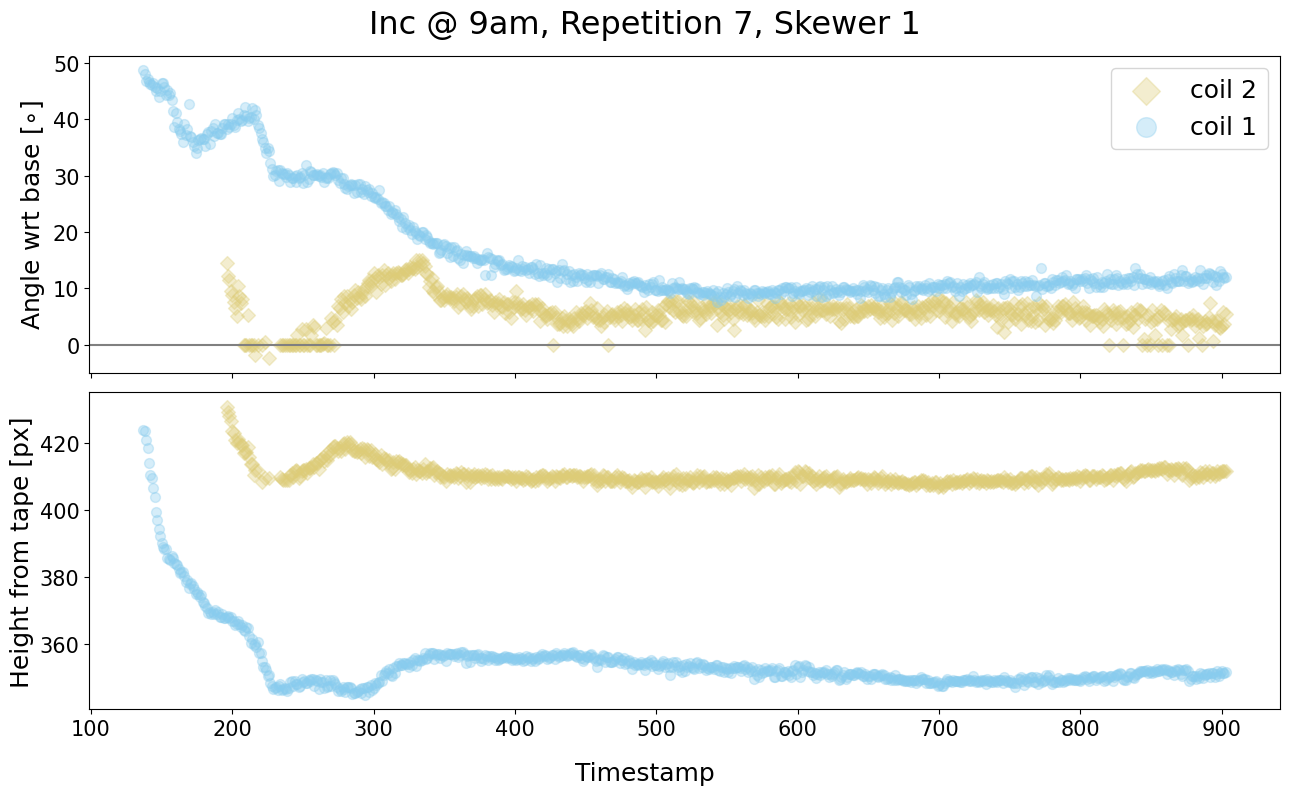

In [268]:
colors = [None, '#117733', '#aa4499', '#332288', '#44aa99', '#88ccee', '#ddcc77']

fs = 18
fig, ax = plt.subplots(2,1,figsize=(13,8), sharex=True, sharey=False)
ax = np.atleast_1d(ax).ravel()

for j in range(1, len(pos)):
    mask = pos[j] > 0
    label = 'coil {}'.format(len(pos) - j)
    ax[0].scatter(pos[0, mask], ang[j, mask], c=colors[-j], marker=markers[j],  zorder=j+1, alpha=0.35, s=50, label=label)
    ax[1].scatter(pos[0, mask], pos[j, mask], c=colors[-j], marker=markers[j],  zorder=j+1, alpha=0.35, s=50)
ax[0].legend(fontsize=fs, markerscale=2);
ax[0].axhline(0, c='gray')

for i in range(len(ax)):
    ax[i].tick_params(labelsize=fs-3)
ax[0].set_ylabel('Angle wrt base [$\circ$]', fontsize=fs)
ax[1].set_ylabel('Height from tape [px]', fontsize=fs)

fig.supxlabel('Timestamp', fontsize=fs)
fig.suptitle('Inc @ {}, Repetition {}, Skewer {}'.format(time, rep, pidx), fontsize=fs+5)
fig.tight_layout()

In [269]:
ipos = pos.copy()
iang = ang.copy()

mss = [ None ]
for j in range(1, len(pos)):
    mss.append( np.s_[np.argmax(pos[j] > 0) : ] )
print(mss)
for j in range(1, len(pos)):
    mask = pos[j] > 0
    interpolated = interpolate.interp1d(ang[0,mask], ang[j, mask], bounds_error=True, kind='linear', assume_sorted=True)
    iang[j, mss[j]] = interpolated(pos[0, mss[j]])

    interpolated = interpolate.interp1d(pos[0,mask], pos[j, mask], bounds_error=True, kind='linear', assume_sorted=True)
    ipos[j, mss[j]] = interpolated(pos[0, mss[j]])

[None, slice(75, None, None), slice(16, None, None)]


In [270]:
mpos = pos.copy()
mang = ang.copy()

wlen = 15
weights = np.ones(wlen, dtype=bool)
for j in range(1, len(pos)):
    mang[j,mss[j]] = signal.savgol_filter(iang[j,mss[j]], window_length=wlen, polyorder=2, deriv=0, delta=1, mode='nearest')
    mpos[j,mss[j]] = signal.savgol_filter(ipos[j,mss[j]], window_length=wlen, polyorder=2, deriv=0, delta=1, mode='nearest')

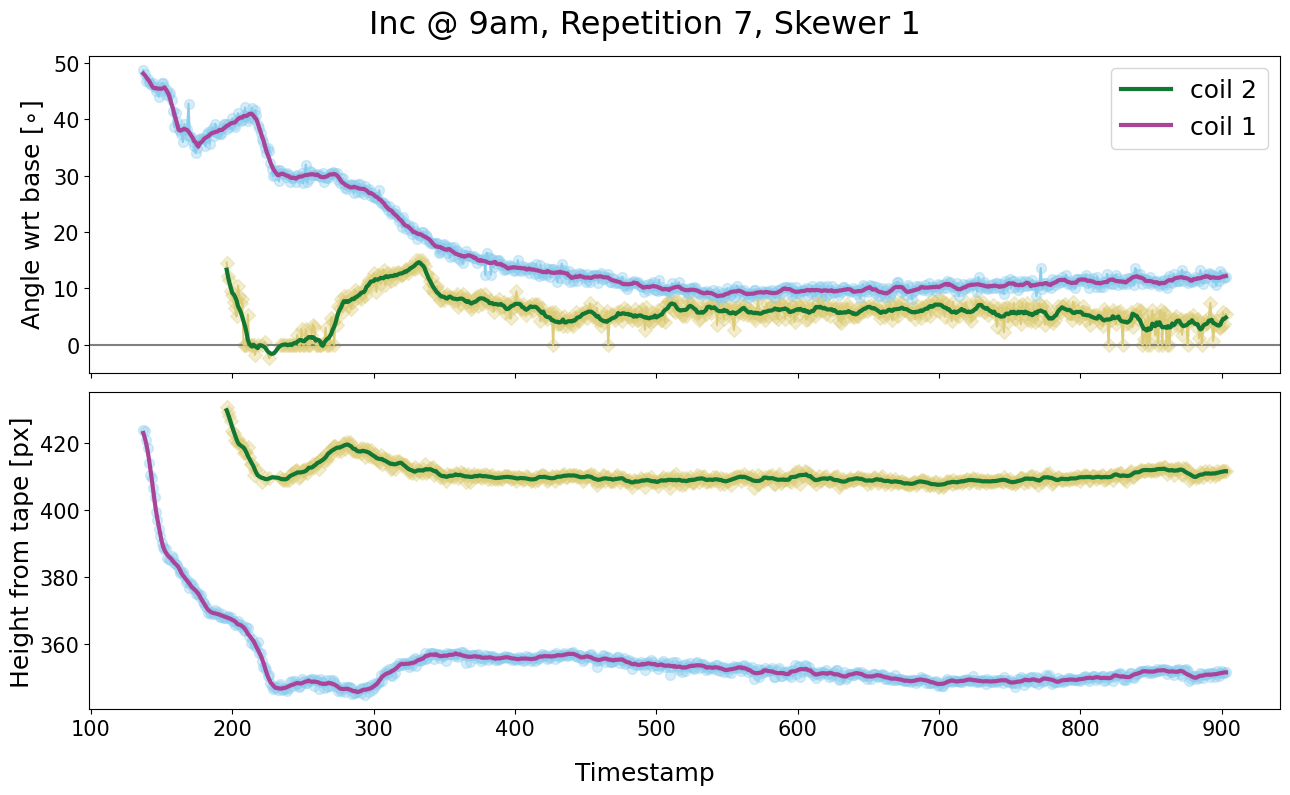

In [271]:
colors = maize_palettes['GlassGem']
colors = np.hstack((colors, colors))
colors = [None, '#117733', '#aa4499', '#332288', '#44aa99', '#88ccee', '#ddcc77']

fs = 18
fig, ax = plt.subplots(2,1,figsize=(13,8), sharex=True, sharey=False)
ax = np.atleast_1d(ax).ravel()

for j in range(1, len(pos)):
    mask = pos[j] > 0
    label = 'coil {}'.format(maxL + 1 - j)
    ax[0].scatter(pos[0, mask], ang[j, mask], c=colors[-j], marker=markers[j],  zorder=j+1, alpha=0.35, s=50)
    ax[1].scatter(pos[0, mask], pos[j, mask], c=colors[-j], marker=markers[j],  zorder=j+1, alpha=0.35, s=50)
    
    ax[0].plot(pos[0, mss[j]], iang[j, mss[j]], c=colors[-j], zorder=20)
    ax[0].plot(pos[0, mss[j]], mang[j, mss[j]], c=colors[j], zorder=23, lw=3, label=label)
    ax[1].plot(pos[0, mss[j]], mpos[j, mss[j]], c=colors[j], zorder=23, lw=3, label=label)

ax[0].legend(fontsize=fs, markerscale=2);
ax[0].axhline(0, c='gray')

for i in range(len(ax)):
    ax[i].tick_params(labelsize=fs-3)
    #ax[i].axvline(450)

ax[0].set_ylabel('Angle wrt base [$\circ$]', fontsize=fs)
ax[1].set_ylabel('Height from tape [px]', fontsize=fs)

fig.supxlabel('Timestamp', fontsize=fs)
fig.suptitle('Inc @ {}, Repetition {}, Skewer {}'.format(time, rep, pidx), fontsize=fs+5)
fig.tight_layout()

filename = dst + time + '_rep{}_plant_{:02d}'.format(rep,pidx)
plt.savefig(filename + '.png', dpi=100, format='png', pil_kwargs={'optimize':True}, bbox_inches='tight')

In [272]:
filename = src + 'prelim/' + time + '_rep{}/{}_rep{}_plant_{:02d}.csv'.format(rep,time,rep,pidx)
print(filename)

df = pd.DataFrame()
df['timestamp'] = pos[0].astype(int)
for i in range(1, len(pos)):
    j = maxL + 1 - i
    foo = 'angle_raw_{}'.format(j)
    df[foo] = ang[i]
    foo = 'angle_interp_{}'.format(j)
    df[foo] = iang[i]
    foo = 'angle_sg_{}'.format(j)
    df[foo] = mang[i]

for i in range(1, len(pos)):
    j = maxL + 1 - i
    foo = 'pos_raw_{}'.format(j)
    df[foo] = pos[i]
    foo = 'pos_interp_{}'.format(j)
    df[foo] = ipos[i]
    foo = 'pos_sg_{}'.format(j)
    df[foo] = mpos[i]

print(df.shape)
df.to_csv(filename, index=False)
df.head()

../proc/prelim/9am_rep7/9am_rep7_plant_01.csv
(783, 13)


,timestamp,angle_raw_2,angle_interp_2,angle_sg_2,angle_raw_1,angle_interp_1,angle_sg_1,pos_raw_2,pos_interp_2,pos_sg_2,pos_raw_1,pos_interp_1,pos_sg_1
0,121,-100.0,-100.0,-100.0,-0.000000,-0.000000,-0.000000,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
1,122,-100.0,-100.0,-100.0,-0.000000,-0.000000,-0.000000,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
2,123,-100.0,-100.0,-100.0,22.956335,22.956335,22.956335,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
3,124,-100.0,-100.0,-100.0,29.280586,29.280586,29.280586,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
4,125,-100.0,-100.0,-100.0,40.262667,40.262667,40.262667,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0


In [63]:
pmax, pmin = np.max(pos[1:]), np.min(pos[1:])
amax, amin = np.max(ang[1:]), np.min(ang[1:])

In [64]:
rscr = '../raw/'
idx = 10
rawname = '{}{} Inc Rep {}/{} Inc Rep {} ({}).JPG'.format(rsrc, time, rep, time, rep, deets[idx]['num'])
print(rawname)
raw = cv2.imread(rawname)

../raw/4pm Inc Rep 7/4pm Inc Rep 7 (205).JPG


In [65]:
print(ang.shape, len(deets), len(meta))

(4, 708) 692 902


KeyboardInterrupt: 

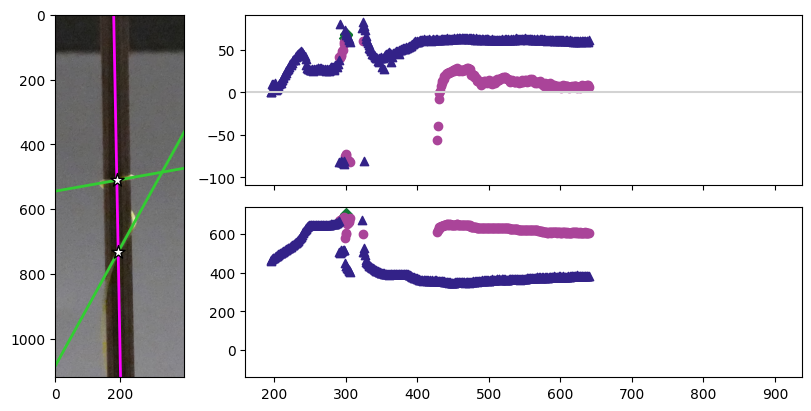

In [66]:
for idx in range(len(deets)):
    rawname = '{}{} Inc Rep {}/{} Inc Rep {} ({}).JPG'.format(rsrc, time, rep, time, rep, deets[idx]['num'])
    raw = cv2.imread(rawname)
    
    fig = plt.figure(layout='constrained', figsize=(8,4))
    gs = GridSpec(2,5, figure=fig)
    ax0 = fig.add_subplot(gs[:,0])
    ax1 = fig.add_subplot(gs[0,1:])
    ax2 = fig.add_subplot(gs[1,1:])
    
    ax = [ax0, ax1, ax2]
    
    ax[0].imshow(raw[stick[deets[idx]['idx']]][:,:,::-1])
    ax[0].plot(lines[deets[idx]['idx'], stick[deets[idx]['idx']][0]] - peak[deets[idx]['idx']] + buffy[deets[idx]['idx']],
               xvals[stick[deets[idx]['idx']][0]] - buffx[deets[idx]['idx']], c='magenta', lw=2)
    
    ax[0].scatter(deets[idx]['comsx'] , deets[idx]['comsy'], c='w', s=100, marker='*', zorder=11, edgecolor='k')
    for i in range(len(deets[idx]['comsx'])):
        ax[0].axline(xy1 = (deets[idx]['comsx'][i], deets[idx]['comsy'][i]), slope = deets[idx]['coef1'][i], c='limegreen', alpha=.5, lw=2)
    
    for j in range(1, len(pos)):
        mask = pos[j, :idx+1] > 0
        label = 'coil {}'.format(maxL + 1 - j)
        ax[1].scatter(ang[:, :idx+1][0, mask], ang[:, :idx+1][j, mask], c=colors[j], marker=markers[j])
        ax[2].scatter(pos[:, :idx+1][0, mask], pos[:, :idx+1][j, mask], c=colors[j], marker=markers[j])
    
    ax[1].scatter([ang[0,0], len(meta)], [amin,amax], c='w', alpha=0);
    ax[1].tick_params(labelbottom=False)
    ax[1].axhline(0, c='lightgray')
    ax[2].scatter([ang[0,0], len(meta)], [pmin,pmax], c='w', alpha=0);
    
    filename = '../proc/anim/' + time + '_rep{}_plant_{:02d}_{:04d}'.format(rep,pidx,deets[idx]['num'])
    plt.savefig(filename + '.png', dpi=100, format='png', pil_kwargs={'optimize':True}, bbox_inches='tight')
    plt.close()